In [25]:
from numba import jit
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np
import math
import matplotlib.pyplot as plt

import time

In [5]:
@cuda.jit
def CLT(rng_states, iterations, out):
    thread_id = cuda.grid(1)
    
    coin_up = 0
    
    for i in range(iterations):
        dx = round(xoroshiro128p_uniform_float32(rng_states,thread_id))
        
        coin_up += dx
        
        
            
    out[thread_id] = coin_up

In [7]:
threads_per_block = 1024
blocks = 1024
iterations = 100000

#1개의 coin에 대해 iteration만큼 coin toss를 실시한다.
#총 coin의 개수는 threads_per_block * blocks 이다.

seed = time.time()

rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed) 
# RNG(Random number generator)의 상태를 초기화해주는 것이다...!

out = np.zeros(threads_per_block*blocks, dtype=np.int)

s = time.time()

CLT[blocks, threads_per_block](rng_states, iterations, out)

e = time.time()

print('it takes', e - s, 'sec')

it takes 0.5162420272827148 sec


mean value :  49999.13879394531
variance value :  24837.395409092307


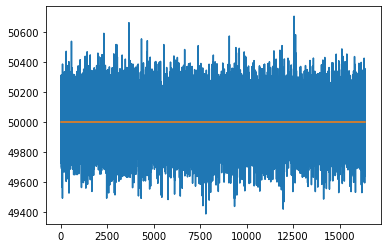

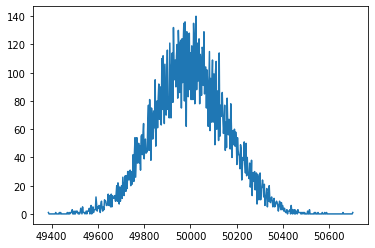

In [14]:
print('mean value : ',out.mean())
print('variance value : ',out.var())
plt.plot(out)
plt.plot([0,threads_per_block*blocks],[out.mean(), out.mean()])
plt.show()

hist, bins = np.histogram(out,500)

plt.plot(bins[:-1],hist)
plt.show()

In [19]:
def coin(n):
    result = np.round(np.random.rand(n),0)
    return result

def CLT_without_cuda(n,r):
    '''
    n : 던지는 동전의 개수
    r : 던지는 횟수
    bin_num : 히스토그램을 그릴 때 자르는 영역의 개수
    '''
    value = np.zeros(n)

    for i in range(0,r):
        value += coin(n)
       
    
    return value

In [21]:
s = time.time()

value = CLT_without_cuda(1024,iterations)

e = time.time()

print('it takes', e - s, 'sec')

it takes 4.658786296844482 sec


cuda를 이용했을때, 1024배 더 많은 개수의 coin을 던졌는데도 전체 속도는 1/9배 걸렸다..

In [26]:
def coin(n):
    result = np.round(np.random.rand(n),0)
    return result

@jit
def CLT_with_jit(n,r):
    '''
    n : 던지는 동전의 개수
    r : 던지는 횟수
    bin_num : 히스토그램을 그릴 때 자르는 영역의 개수
    '''
    value = np.zeros(n)

    for i in range(0,r):
        value += coin(n)
       
    
    return value

In [27]:
s = time.time()

value = CLT_without_cuda(1024,iterations)

e = time.time()

print('it takes', e - s, 'sec')

it takes 4.683400392532349 sec


@jit의 경우 cpu 병렬 계산을 해준다. cpu 병렬화는 이미 numpy에서 이루어졌기에 속도의 큰 변화가 없다.(오히려 느려져보인다.)